In [188]:
import numpy as np
import pandas as pd
import glob
import os
import googlemaps
import geocoder
import folium
import matplotlib.pyplot as plt
import geojsoncontour

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from folium.plugins import MarkerCluster
from scipy.interpolate import griddata

In [189]:
path = '../src/data/trip_data'
all_files = glob.glob(os.path.join(path , "*.csv"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [190]:
df.head()

,Unnamed: 0,Device,DeviceGroup,StartDate,Duration,EndDate,Distance,StopDuration,Location,StopZoneType,IdleDuration,MaxSpeed,lat,long
0,0.0,FO15921,Hospital ITS,"September 27, 2022",6,"Sep 27, 2022 8:42:12 AM",3,0:07,"1690 S 900 W, Salt Lake City, UT 84104, USA",NaN,0,68,40.733824,-111.917589
1,1.0,FO15921,Hospital ITS,"September 27, 2022",4,"Sep 27, 2022 8:53:34 AM",1,1:53,"1525 2100 S, Salt Lake City, UT 84119, USA",NaN,0,42,40.725374,-111.933127
2,2.0,FO15921,Hospital ITS,"September 27, 2022",4,"Sep 27, 2022 10:51:02 AM",2,0:03,"1690 S 900 W, Salt Lake City, UT 84104, USA",NaN,0,45,40.733824,-111.917589
3,3.0,FO15921,Hospital ITS,"September 27, 2022",10,"Sep 27, 2022 11:05:09 AM",3,1:04,"75 W 900 S, Salt Lake City, UT 84101, USA",NaN,0,35,40.749723,-111.893200
4,4.0,FO15921,Hospital ITS,"September 27, 2022",8,"Sep 27, 2022 12:18:46 PM",2,0:02,"780 1300 E, Salt Lake City, UT 84102, USA",NaN,0,39,40.752255,-111.854501


In [191]:
df['Duration'] = df['Duration'].apply(lambda d: int(d[:1])*60 + int(d[2:]))
df['IdleDuration'] = df['IdleDuration'].apply(lambda d: int(d[:1])*60 + int(d[2:]))

TypeError: 'int' object is not subscriptable

In [ ]:
df['lat'] = np.nan
df['long'] = np.nan

In [ ]:
df.head()

,Device,DeviceGroup,StartDate,Duration,EndDate,Distance,StopDuration,Location,StopZoneType,IdleDuration,MaxSpeed,lat,long
0,FO15921,Hospital ITS,"September 27, 2022",6,"Sep 27, 2022 8:42:12 AM",3,0:07,"1690 S 900 W, Salt Lake City, UT 84104, USA",NaN,0,68,NaN,NaN
1,FO15921,Hospital ITS,"September 27, 2022",4,"Sep 27, 2022 8:53:34 AM",1,1:53,"1525 2100 S, Salt Lake City, UT 84119, USA",NaN,0,42,NaN,NaN
2,FO15921,Hospital ITS,"September 27, 2022",4,"Sep 27, 2022 10:51:02 AM",2,0:03,"1690 S 900 W, Salt Lake City, UT 84104, USA",NaN,0,45,NaN,NaN
3,FO15921,Hospital ITS,"September 27, 2022",10,"Sep 27, 2022 11:05:09 AM",3,1:04,"75 W 900 S, Salt Lake City, UT 84101, USA",NaN,0,35,NaN,NaN
4,FO15921,Hospital ITS,"September 27, 2022",8,"Sep 27, 2022 12:18:46 PM",2,0:02,"780 1300 E, Salt Lake City, UT 84102, USA",NaN,0,39,NaN,NaN


In [ ]:
for index, row in df.iterrows():
    location = row.Location
    g = geocoder.arcgis(location)
    if g.json is not None:
        df.lat.iloc[index] = g.json['lat']
        df.long.iloc[index] = g.json['lng']

C:\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
df.to_csv('../src/data/trip_data/9-27-9-29_trip_latlng.csv', encoding='utf-8')

In [ ]:
SLC_COORDINATES = [40.7608, -111.891]

slc = folium.Map(location=SLC_COORDINATES, zoom_start=12)
marker_cluster = MarkerCluster().add_to(slc)

for index, row in df.iterrows():
    location = [row["lat"],row["long"]]
    folium.Marker(location).add_to(marker_cluster)

    # slc.Marker(
    #     location = [row["lat"],row["long"]],
    #     clustered_marker = True)

slc.save('stops.html')

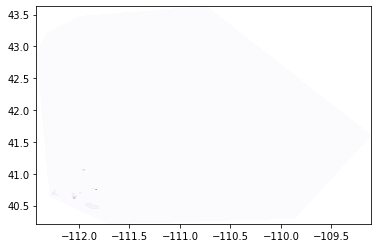

In [192]:
df_c = df[df.lat > 40]

y = df_c['lat']
x = df_c['long']
z = df_c['IdleDuration']

xi = np.linspace(x.min(),x.max(),500);
yi = np.linspace(y.min(),y.max(),500);
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

#alphas[:, 30:] = np.linspace(1, 0, 70)
countour = plt.contourf(xi,yi,zi,cmap='Reds', alpha=0.3)

In [ ]:
geojson = geojsoncontour.contourf_to_geojson(
    contourf=countour,
    ndigits=3,
   )

In [ ]:
with open('countour_geojson.txt', 'w') as f:
    f.write(geojson)

In [ ]:
# Convert text file to JSON 
import json 
with open('countour_geojson.txt') as json_file:     # name of the text file
    data = json.load(json_file)

# Convert JSON to GeoJson 
from geojson import dump
with open('countour_geojson.geojson', 'w') as f:   # name of the output geojson file
   dump(data, f)